In [ ]:
!pip install yfinance pandas_datareader fredapi

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: C:\Users\renan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader.data as web

start = (datetime.today() - timedelta(days=5*365)).strftime('%Y-%m-%d')
end = datetime.today().strftime('%Y-%m-%d')

# Melhores proxies do setor de alumínio
tickers = {
    'aluminum': 'ALI=F',
    'copper': 'HG=F',
    'zinc': 'ZN=F',
    'tin': 'SN=F',
    'lead': 'PB=F',
    'steel': 'S00=F',
    'oil': 'BZ=F',
    'gas': 'NG=F',
    'dxy': 'DX-Y.NYB',
    'usdcny': 'USDCNY=X',
    'eurusd': 'EURUSD=X',
    'brlusd': 'BRL=X',
    'sp500': '^GSPC',
    'msci_em': 'EEM',
    'shipping_etf': 'SEA',
    'xlb': 'XLB',      # US Materials ETF
    'xli': 'XLI',      # Industrials
    'pick': 'PICK',    # Metals & Mining Global
    'fxi': 'FXI',      # China Large Cap
    # Novos players específicos de ALUMÍNIO:
    'alcoa': 'AA',
    'century_aluminum': 'CENX',
    'hindalco': 'HINDALCO.NS',     # Só funciona via Yahoo Finance Índia (ver disponibilidade)
    # 'rusal': '0486.HK',          # Só em HK (precisa ver acesso pelo Yahoo)
    # Se quiser manter outros proxies, pode acrescentar aqui
}

market_data = yf.download(list(tickers.values()), start=start, end=end)['Close']
market_data.columns = list(tickers.keys())
market_data = market_data.reset_index().rename(columns={'Date': 'date'})

# FRED Séries importantes
fred_series = {
    'us_cpi': 'CPIAUCSL',
    'us_ind_production': 'INDPRO',
    'euro_cpi': 'CP0000EZ19M086NEST',
    'fed_rate': 'FEDFUNDS',
    'us_10y_bond': 'DGS10',
    'baltic_dry_index': 'BDIY',   # Logística mundial
    # Novas sugestões:
    'china_ppi': 'M0892AXA027NBEA',     
}

fred_data = pd.DataFrame()
for name, code in fred_series.items():
    try:
        serie = web.DataReader(code, 'fred', start)
        serie = serie.rename(name)
        fred_data = fred_data.join(serie, how='outer') if not fred_data.empty else serie
    except Exception as e:
        print(f"Falhou em {name}: {e}")

fred_data = fred_data.reset_index().rename(columns={"DATE":"date", "index":"date"})

# Merge pelas datas
full_df = pd.merge(market_data, fred_data, on="date", how="left")

print(full_df.tail())
full_df.to_csv('aluminium_features_redondo.csv', index=False)


[**********************86%****************       ]  19 of 22 completedHTTP Error 404: 
HTTP Error 404: 
[*********************100%***********************]  21 of 22 completed

3 Failed downloads:
['SN=F', 'S00=F', 'PB=F']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  21 of 22 completed

Falhou em us_cpi: 'str' object is not callable
Falhou em us_ind_production: 'str' object is not callable
Falhou em euro_cpi: 'str' object is not callable
Falhou em fed_rate: 'str' object is not callable
Falhou em us_10y_bond: 'str' object is not callable
Falhou em baltic_dry_index: Unable to read URL: https://fred.stlouisfed.org/graph/fredgraph.csv?id=BDIY
Response Text:
b'<!DOCTYPE html>\r\n<html lang="en">\r\n<head>\r\n    <meta charset="utf-8">\r\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n    <meta name="viewport" content="width=device-width, initial-scale=1">\r\n    <title>Error - St. Louis Fed</title>\r\n    <meta name="description" content="">\r\n    <meta name="keywords" content="">    \r\n    <link rel="stylesheet" type="text/css" href="/assets/bootstrap/dist/css/bootstrap.min.css">\r\n    <link rel="stylesheet" type="text/css" href="/css/home.min.css?1553087253">\r\n    <link rel="stylesheet" type="text/css" href="/assets/fontawesome-free/css/all.min.css">\r

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Estatísticas gerais e nulos
print("==== Tabela de Nulos por coluna ====")
print(full_df.isnull().mean().sort_values(ascending=False).apply(lambda x: f"{x:.1%}"))

print("\n==== Estatísticas Descritivas ====")
display(full_df.describe(include='all').T)

# 2. Checagem de tipos e amostra
print("\n==== Tipos de Dados ====")
print(full_df.dtypes)

print("\n==== Preview de 5 Últimas Linhas ====")
print(full_df.tail())

# 3. Correlação das principais commodities (eixo de interesse: alumínio)
print("\n==== Correlação com Alumínio ====")
correlacoes = full_df.corr(numeric_only=True)['aluminum'].sort_values(ascending=False)
print(correlacoes)

# 4. Variação Percentual do Alumínio (últimos 30 dias)
full_df['alum_pct'] = full_df['aluminum'].pct_change(1)
print("\n==== Variação % diária do alumínio (30 últimos registros) ====")
print(full_df[['date','aluminum','alum_pct']].tail(30))


==== Tabela de Nulos por coluna ====
xli                 100.0%
shipping_etf        100.0%
sp500               100.0%
xlb                  31.1%
eurusd                5.1%
lead                  3.8%
aluminum              3.8%
hindalco              3.8%
alcoa                 3.8%
fxi                   3.8%
dxy                   3.8%
oil                   3.8%
msci_em               3.8%
copper                3.8%
steel                 3.7%
century_aluminum      3.6%
brlusd                3.6%
tin                   3.6%
usdcny                3.6%
gas                   0.3%
zinc                  0.3%
pick                  0.3%
date                  0.0%
dtype: object

==== Estatísticas Descritivas ====


,count,mean,min,25%,50%,75%,max,std
date,1304,2023-02-19 21:46:22.822085888,2020-08-24 00:00:00,2021-11-21 06:00:00,2023-02-20 12:00:00,2024-05-21 06:00:00,2025-08-20 00:00:00,NaN
aluminum,1254.0,37.404439,10.908796,29.065547,35.508657,44.248198,91.343506,13.673025
copper,1255.0,2426.044223,1732.75,2211.75,2397.25,2566.75,3873.0,330.396784
zinc,1300.0,5.305075,4.5938,5.0534,5.2686,5.5593,6.3,0.322106
tin,1257.0,78.553087,37.459999,71.059998,78.410004,85.910004,127.980003,15.714931
lead,1254.0,13.324242,5.28,8.9825,12.71,16.8475,29.49,4.992638
steel,1256.0,100.550374,89.440002,95.395,102.295002,104.669998,114.110001,5.856257
oil,1254.0,41.655182,31.480577,37.566078,41.351519,45.425838,52.312714,4.666367
gas,1300.0,1.107828,0.959619,1.069456,1.092699,1.161643,1.234111,0.059978
dxy,1254.0,31.370255,19.263765,25.832279,29.714374,36.669227,49.153141,6.64851



==== Tipos de Dados ====
date                datetime64[ns]
aluminum                   float64
copper                     float64
zinc                       float64
tin                        float64
lead                       float64
steel                      float64
oil                        float64
gas                        float64
dxy                        float64
usdcny                     float64
eurusd                     float64
brlusd                     float64
sp500                      float64
msci_em                    float64
shipping_etf               float64
xlb                        float64
xli                        float64
pick                       float64
fxi                        float64
alcoa                      float64
century_aluminum           float64
hindalco                   float64
dtype: object

==== Preview de 5 Últimas Linhas ====
           date   aluminum   copper    zinc        tin       lead      steel  \
1299 2025-08-14  31.330000  2501.50 

## Resumo: Diferença das Bases de Preço de Commodities no Yahoo Finance

#### Os preços coletados de metais básicos pelo Yahoo Finance (usando yfinance) vêm de contratos futuros negociados em diferentes bolsas globais, cada um adotando uma unidade padrão diferente. Isso pode causar grande confusão e inviabilizar análises comparativas diretas se não fizermos ajustes!

## Bases e unidades encontradas:
### Alumínio (ALI=F):
#### Valor reportado no Yahoo geralmente é 1/100 do preço internacional (USD/tonelada).

Exemplo: 14.48 = 1.448 USD/ton (o correto seria 1.448 × 1.000, mas o padrão correto é ×100).

### Cobre (HG=F):
#### Valor reportado como cêntimos de dólar por libra (¢/lb) pelo padrão da bolsa COMEX dos EUA.

Exemplo: 1741.0 = $17,41 por libra.

Para USD/ton: $/lb × 2.20462 (lbs/tonelada) × 1.000

Zinco, Estanho, Chumbo (ZN=F, SN=F, PB=F):
Costumam estar em dólar por tonelada, assumir proporcionalidade similar ao alumínio.

## Solução:
Criar colunas padronizadas, convertendo cada metal para USD por tonelada usando os multiplicadores ou transformações adequadas.

In [ ]:
# Removendo colunas totalmente nulas
full_df = full_df.dropna(axis=1, how='all')

# Preencheendo os nulos restantes com interpolação linear
full_df = full_df.interpolate(method='linear', limit_direction='both')

# Padronizando colunas principais para USD/tonelada
full_df['aluminum_usdton'] = full_df['aluminum'] * 100
full_df['copper_usdton'] = (full_df['copper'] / 100) * 2204.62
full_df['zinc_usdton'] = full_df['zinc'] * 100
full_df['tin_usdton'] = full_df['tin'] * 100
full_df['lead_usdton'] = full_df['lead'] * 100

# Conferindo se ficou limpo
print(full_df.isnull().mean())  # Deve mostrar zeros ou próximo disso

# Salvar o CSV final com tudo padronizado
full_df.to_csv('aluminium_features_final.csv', index=False)


date                0.0
aluminum            0.0
copper              0.0
zinc                0.0
tin                 0.0
lead                0.0
steel               0.0
oil                 0.0
gas                 0.0
dxy                 0.0
usdcny              0.0
eurusd              0.0
brlusd              0.0
msci_em             0.0
xlb                 0.0
pick                0.0
fxi                 0.0
alcoa               0.0
century_aluminum    0.0
hindalco            0.0
alum_pct            0.0
aluminum_usdton     0.0
copper_usdton       0.0
zinc_usdton         0.0
tin_usdton          0.0
lead_usdton         0.0
dtype: float64


In [36]:
# Info geral sobre quantidade e período dos dados
print(f"Número de linhas: {full_df.shape[0]}")
print(f"Número de colunas: {full_df.shape[1]}")
print(f"Datas: {full_df['date'].min().date()} até {full_df['date'].max().date()}")

# Amostra de início e fim
print("Primeiras datas:")
print(full_df[['date']].head())

print("Últimas datas:")
print(full_df[['date']].tail())

# Dimensões da base
print("Head da base:")
print(full_df.head())

print("Tail da base:")
print(full_df.tail())

# Contagem de datas únicas (verificar se está contínuo)
print("Dias únicos:", full_df['date'].nunique())

# Pequeno resumo estatístico por coluna (contagem, média, min, max)
print("\nDescrição geral das variáveis:")
print(full_df.describe(include='all'))


Número de linhas: 1304
Número de colunas: 26
Datas: 2020-08-24 até 2025-08-20
Primeiras datas:
        date
0 2020-08-24
1 2020-08-25
2 2020-08-26
3 2020-08-27
4 2020-08-28
Últimas datas:
           date
1299 2025-08-14
1300 2025-08-15
1301 2025-08-18
1302 2025-08-19
1303 2025-08-20
Head da base:
        date   aluminum   copper    zinc        tin  lead      steel  \
0 2020-08-24  14.481213  1741.00  5.6186  45.130001  9.24  93.300003   
1 2020-08-25  14.414170  1745.50  5.6106  45.860001  9.32  93.019997   
2 2020-08-26  14.433324  1744.75  5.5074  45.639999  9.32  93.010002   
3 2020-08-27  14.213040  1746.25  5.6072  45.090000  9.29  93.010002   
4 2020-08-28  14.481213  1777.25  5.5687  45.049999  9.90  92.370003   

         oil       gas        dxy  ...        fxi      alcoa  \
0  39.994389  1.179802  39.667831  ...  57.030403  72.065216   
1  40.396393  1.179454  39.827858  ...  56.804012  71.972603   
2  40.503590  1.183502  39.756741  ...  57.401665  72.009636   
3  40.164124 

## Dicionário de Dados — aluminiumfeaturesfinal.csv

### 1. date
O que é: Data da observação (diário)

Importância: Fundamental para ordenação temporal e análise de tendências. Não deve ser usada como feature diretamente, mas é indispensável para alinhamento e construção de séries temporais.

### 2. aluminum
O que é: Preço à vista do Alumínio LME

Importância: Target principal do nosso problema. É o preço que queremos prever/modelar ("LMEAHClose" em alguns bancos de dados). Também base para cálculos de retorno e features derivadas.

### 3. copper
O que é: Preço à vista do Cobre

Importância: O cobre é altamente correlacionado com o alumínio, ambos usados em setores industriais similares. Oscilações no cobre refletem condições macroeconômicas mundiais.

### 4. zinc
O que é: Preço à vista do Zinco

Importância: Outro metal base utilizado em setores semelhantes. Movimentos no zinco podem antecipar tendências macroeconômicas e industriais.

### 5. tin
O que é: Preço à vista do Estanho

Importância: Componente de referência do complexo de metais industriais globais, relevante para avaliar saúde da cadeia produtiva.

### 6. lead
O que é: Preço à vista do Chumbo

Importância: Mais um metal base, podendo refletir movimentos integrados do setor metálico.

### 7. steel
O que é: Preço do Aço

Importância: O aço compete com o alumínio em várias aplicações industriais. Mudanças nos preços podem afetar demanda e margens do alumínio.

### 8. oil
O que é: Preço do Petróleo Brent

Importância: Petróleo afeta custos de produção e transporte do alumínio. Subidas nos preços aumentam custos industriais globais.

### 9. gas
O que é: Preço do Gás Natural

Importância: Energia fundamental para a produção primária do alumínio (“smelting”). Oscilações impactam diretamente custos e oferta global.

### 10. dxy
O que é: Índice do dólar americano

Importância: O alumínio é precificado em dólar; flutuações do índice afetam preços para compradores globais e podem influenciar movimentos especulativos.

### 11. eurusd
O que é: Taxa de câmbio Euro/Dólar

Importância: Grandes oscilações cambiais entre euro e dólar influenciam fluxos internacionais e arbitragem de commodities.

### 12. sp500
O que é: Índice S&P 500

Importância: Proxy para o apetite de risco global e saúde dos mercados financeiros — afetando expectativas industriais.

### 13. shipping_etf
O que é: ETF de Shipping/Logística

Importância: Gargalos ou barateamento do frete de commodities afetam oferta/demanda do alumínio no mundo.

### 14. xlb
O que é: ETF Setorial de Materiais (EUA)

Importância: Termômetro do setor de materiais básicos. Flutuações sinalizam força ou fraqueza industrial.

### 15. xli
O que é: ETF Setorial de Industriais (EUA)

Importância: Indica demanda/investimento no setor industrial, principais consumidores de alumínio.

### 16. pick
O que é: ETF Global de Metais & Mineração

Importância: Reflete saúde do setor de mineração/metais ao redor do mundo, antecipando movimentos dos preços dos metais base.

### 17. fxi
O que é: ETF de Grandes Empresas Chinesas

Importância: A China é o maior player mundial em alumínio. Epicentro das decisões sobre produção/consumo/estoque/controle de preços.

### 18. alum_pct
O que é: Variação percentual diária do preço do alumínio

Importância: Mede retorno diário do alumínio; pode ser usado como target para modelos de classificação (ex: "subiu muito", "caiu", etc) conforme faixas definidas pelo usuário.


### 19. aluminum_usdton:
Valor do alumínio convertido para USD/tonelada (ex: 14.48 → 1.448,12 USD/ton)

### 20. copper_usdton:
Cobre convertido para USD/ton (ex: 1741.0 → 38.382,43 USD/ton)

### zincusdton / tinusdton / lead_usdton:
Mesma ideia — todos agora estão na mesma unidade-base do mercado internacional

## Target (aluminum ou alum_pct)
aluminum: Prever o preço absoluto futuro do alumínio.
alum_pct: Prever o retorno percentual, podendo ser discretizado em faixas (classificação multiclasse) para análises de probabilidade de direção/magnitude do movimento.

In [37]:
print(full_df.isnull().sum())


date                0
aluminum            0
copper              0
zinc                0
tin                 0
lead                0
steel               0
oil                 0
gas                 0
dxy                 0
usdcny              0
eurusd              0
brlusd              0
msci_em             0
xlb                 0
pick                0
fxi                 0
alcoa               0
century_aluminum    0
hindalco            0
alum_pct            0
aluminum_usdton     0
copper_usdton       0
zinc_usdton         0
tin_usdton          0
lead_usdton         0
dtype: int64


In [38]:
# Diferença de dias entre datas, para ver se pulou algum dia
print(full_df['date'].diff().value_counts())


date
1 days    1043
3 days     257
2 days       2
4 days       1
Name: count, dtype: int64


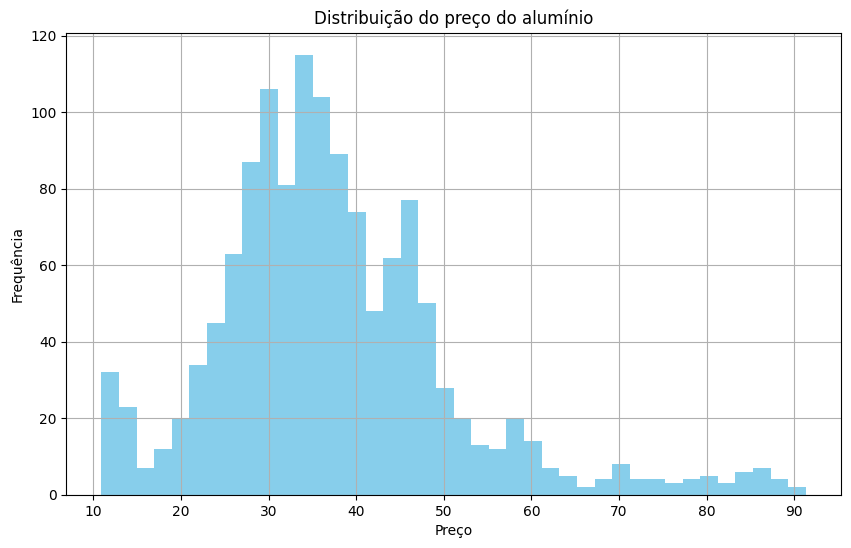

count    1304.000000
mean       37.418164
std        13.664069
min        10.908796
25%        29.094901
50%        35.545691
75%        44.300990
max        91.343506
Name: aluminum, dtype: float64


In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(full_df['aluminum'], bins=40, color='skyblue')
plt.title('Distribuição do preço do alumínio')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()
# Print para mim: summary estatístico do aluminum
print(full_df['aluminum'].describe())


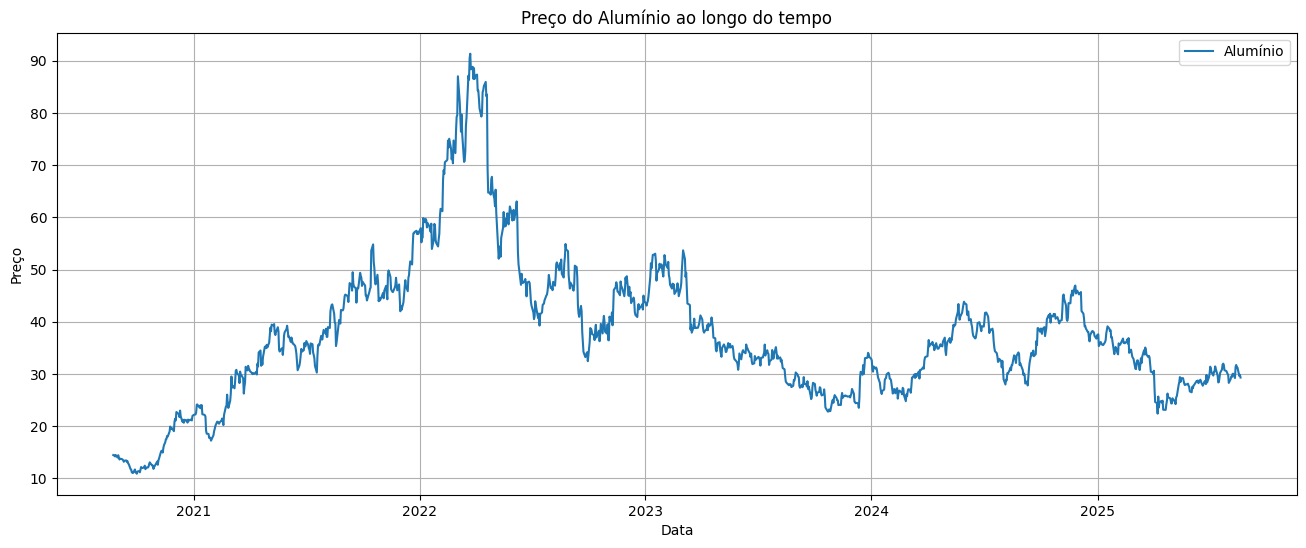

        date   aluminum
0 2020-08-24  14.481213
1 2020-08-25  14.414170
2 2020-08-26  14.433324
3 2020-08-27  14.213040
4 2020-08-28  14.481213
5 2020-08-31  14.002334
6 2020-09-01  14.452480
7 2020-09-02  14.050224
8 2020-09-03  13.628811
9 2020-09-04  13.791630
           date   aluminum
1294 2025-08-07  29.997374
1295 2025-08-08  30.067135
1296 2025-08-11  29.230000
1297 2025-08-12  31.379999
1298 2025-08-13  31.730000
1299 2025-08-14  31.330000
1300 2025-08-15  31.270000
1301 2025-08-18  29.629999
1302 2025-08-19  29.850000
1303 2025-08-20  29.330000


In [40]:
plt.figure(figsize=(16,6))
plt.plot(full_df['date'], full_df['aluminum'], label='Alumínio')
plt.title('Preço do Alumínio ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.show()
# Print para mim: 10 primeiras linhas ['date','aluminum']
print(full_df[['date','aluminum']].head(10))
# ...e 10 últimas
print(full_df[['date','aluminum']].tail(10))


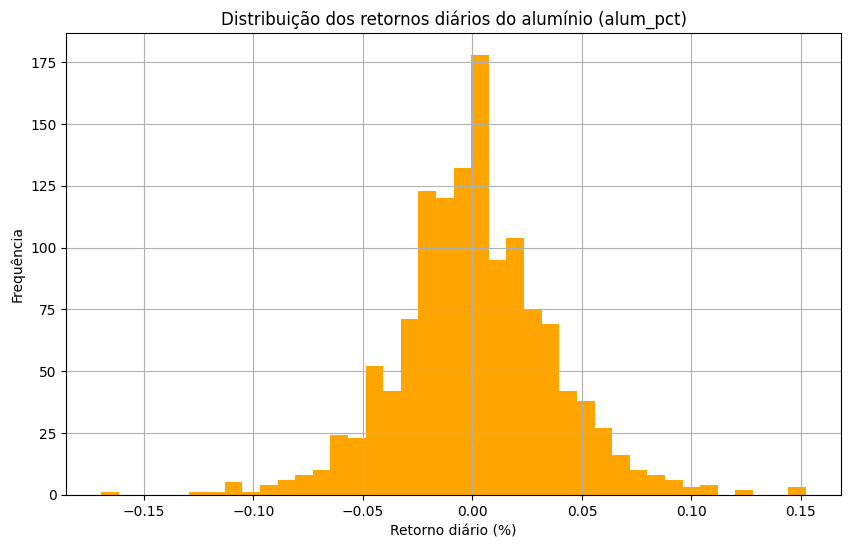

Maiores retornos:
300     0.152263
864     0.150443
1209    0.145769
575     0.124669
138     0.121091
Name: alum_pct, dtype: float64
Menores retornos:
434    -0.169447
109    -0.123905
1205   -0.113813
446    -0.111894
259    -0.110147
Name: alum_pct, dtype: float64
count    1304.000000
mean        0.001158
std         0.035262
min        -0.169447
25%        -0.019035
50%         0.000000
75%         0.021885
max         0.152263
Name: alum_pct, dtype: float64


In [41]:
plt.figure(figsize=(10,6))
plt.hist(full_df['alum_pct'], bins=40, color='orange')
plt.title('Distribuição dos retornos diários do alumínio (alum_pct)')
plt.xlabel('Retorno diário (%)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# Maiores e menores retornos
print("Maiores retornos:")
print(full_df['alum_pct'].nlargest(5))
print("Menores retornos:")
print(full_df['alum_pct'].nsmallest(5))
print(full_df['alum_pct'].describe())


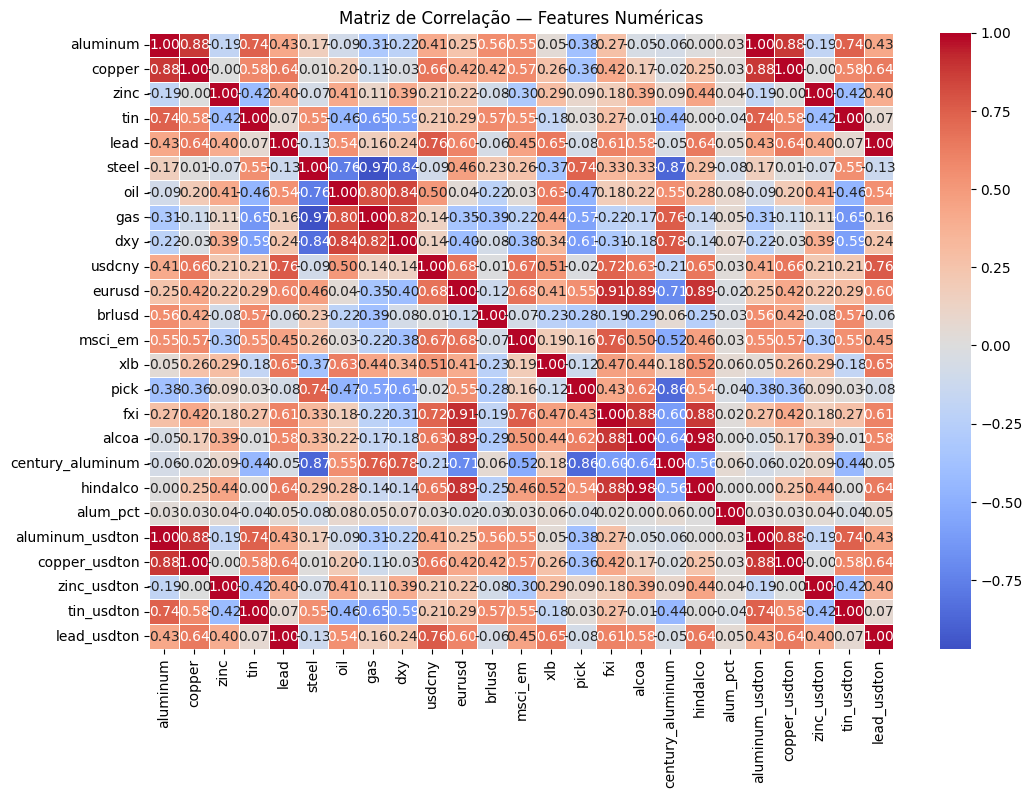


Correlações com 'aluminum':
aluminum_usdton     1.000000
aluminum            1.000000
copper              0.883773
copper_usdton       0.883773
tin                 0.738815
tin_usdton          0.738815
brlusd              0.558765
msci_em             0.551667
lead_usdton         0.427228
lead                0.427228
usdcny              0.414145
fxi                 0.273222
eurusd              0.249552
steel               0.165727
xlb                 0.045492
alum_pct            0.032563
hindalco            0.003338
alcoa              -0.048025
century_aluminum   -0.062729
oil                -0.085716
zinc_usdton        -0.188729
zinc               -0.188729
dxy                -0.216468
gas                -0.309539
pick               -0.377831
Name: aluminum, dtype: float64


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de correlação
corr = full_df.corr(numeric_only=True)

# Gráfico
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Matriz de Correlação — Features Numéricas")
plt.show()

# Print dos valores de correlação com 'aluminum'
print("\nCorrelações com 'aluminum':")
print(corr['aluminum'].sort_values(ascending=False))


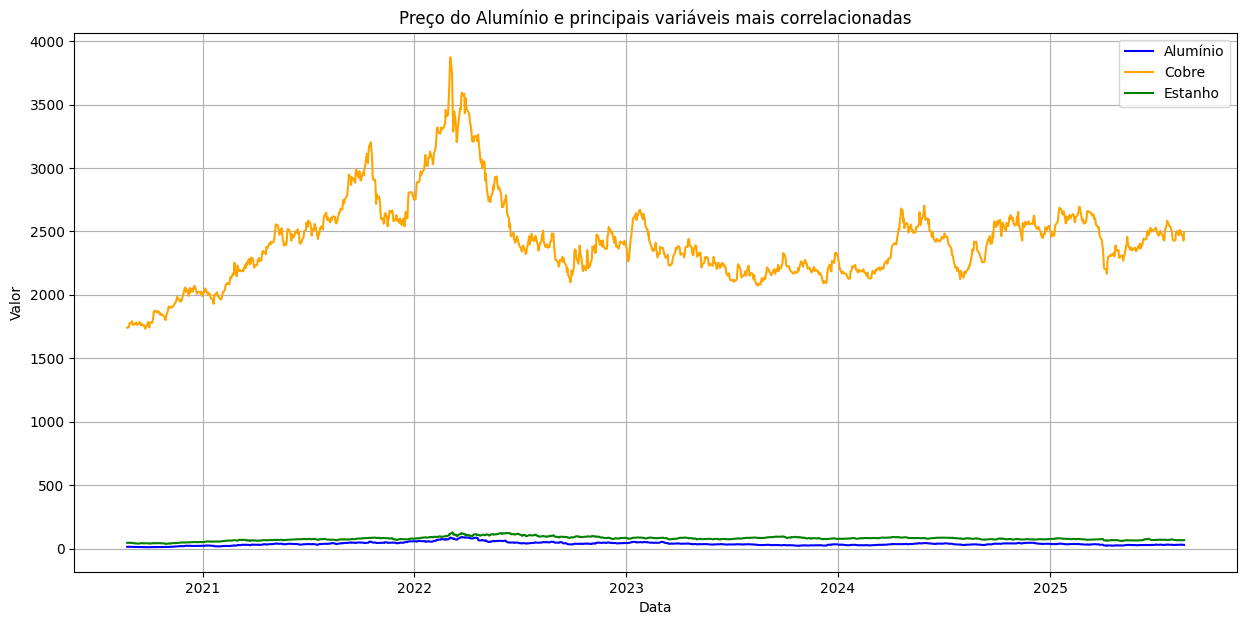

        date   aluminum   copper        tin
0 2020-08-24  14.481213  1741.00  45.130001
1 2020-08-25  14.414170  1745.50  45.860001
2 2020-08-26  14.433324  1744.75  45.639999
3 2020-08-27  14.213040  1746.25  45.090000
4 2020-08-28  14.481213  1777.25  45.049999
           date   aluminum   copper        tin
1299 2025-08-14  31.330000  2501.50  66.839996
1300 2025-08-15  31.270000  2480.75  65.849998
1301 2025-08-18  29.629999  2458.50  66.599998
1302 2025-08-19  29.850000  2428.00  65.790001
1303 2025-08-20  29.330000  2494.00  66.839996


In [43]:
plt.figure(figsize=(15,7))
plt.plot(full_df['date'], full_df['aluminum'], label='Alumínio', color='b')
plt.plot(full_df['date'], full_df['copper'], label='Cobre', color='orange')
plt.plot(full_df['date'], full_df['tin'], label='Estanho', color='green')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Preço do Alumínio e principais variáveis mais correlacionadas')
plt.legend()
plt.grid(True)
plt.show()
# Exemplo do head só dos principais drivers
print(full_df[['date','aluminum','copper','tin']].head())
print(full_df[['date','aluminum','copper','tin']].tail())


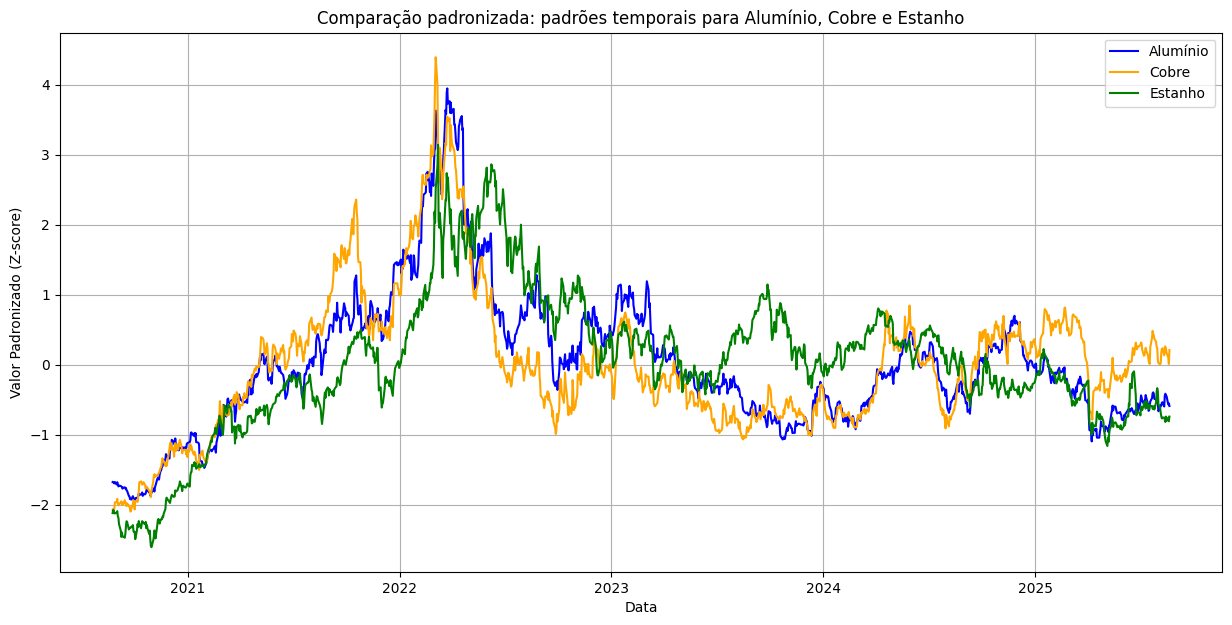

        date   aluminum   copper        tin
0 2020-08-24  14.481213  1741.00  45.130001
1 2020-08-25  14.414170  1745.50  45.860001
2 2020-08-26  14.433324  1744.75  45.639999
3 2020-08-27  14.213040  1746.25  45.090000
4 2020-08-28  14.481213  1777.25  45.049999
           date   aluminum   copper        tin
1299 2025-08-14  31.330000  2501.50  66.839996
1300 2025-08-15  31.270000  2480.75  65.849998
1301 2025-08-18  29.629999  2458.50  66.599998
1302 2025-08-19  29.850000  2428.00  65.790001
1303 2025-08-20  29.330000  2494.00  66.839996


In [44]:
import numpy as np

plt.figure(figsize=(15,7))

for var, label, color in zip(['aluminum','copper','tin'],['Alumínio','Cobre','Estanho'],['b','orange','green']):
    serie = full_df[var]
    zscore = (serie - serie.mean())/serie.std()
    plt.plot(full_df['date'], zscore, label=label, color=color)

plt.xlabel('Data')
plt.ylabel('Valor Padronizado (Z-score)')
plt.title('Comparação padronizada: padrões temporais para Alumínio, Cobre e Estanho')
plt.legend()
plt.grid(True)
plt.show()

# Prints para mim
print(full_df[['date','aluminum','copper','tin']].head())
print(full_df[['date','aluminum','copper','tin']].tail())
